Baixo (1468, 37)
(441, 37)
(1027, 37)
MLflow Experiment 'Competicao_Modelos_Protesto_2025-10-02' configurado.
>>> Etapa 1.1: Carregando e limpando dados...
>>> Etapa 1.3: Realizando engenharia de features...

>>> Foram removidas 1 linhas com idade fora do intervalo [18, 120].
>>> Etapa 1.2: Validando dados iniciais...
Validação de dados iniciais concluída com sucesso.

--- Otimizando XGBoost ---


2025/10/02 15:20:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhor F1-score (CV): 0.8134
Treinando e calibrando XGBoost...
F1-score (Teste): 0.7945
accuracy_score 92.71844660194175
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       169
           1       0.81      0.78      0.79        37

    accuracy                           0.93       206
   macro avg       0.88      0.87      0.88       206
weighted avg       0.93      0.93      0.93       206



2025/10/02 15:20:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Otimizando LightGBM ---


2025/10/02 15:21:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhor F1-score (CV): 0.8298
Treinando e calibrando LightGBM...
F1-score (Teste): 0.8108
accuracy_score 93.20388349514563
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       169
           1       0.81      0.81      0.81        37

    accuracy                           0.93       206
   macro avg       0.88      0.88      0.88       206
weighted avg       0.93      0.93      0.93       206



2025/10/02 15:21:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Otimizando CatBoost ---


2025/10/02 15:23:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhor F1-score (CV): 0.8311
Treinando e calibrando CatBoost...
F1-score (Teste): 0.8767
accuracy_score 95.63106796116504
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       169
           1       0.89      0.86      0.88        37

    accuracy                           0.96       206
   macro avg       0.93      0.92      0.93       206
weighted avg       0.96      0.96      0.96       206



2025/10/02 15:24:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏆 MODELO CAMPEÃO: CatBoost com F1-score de teste de 0.8767
Run ID no MLflow: 569eff0d41684e08be4c7171c3448b2e



>>> Análise detalhada do CatBoost...

--- Relatório de Classificação do Modelo Campeão ---
              precision    recall  f1-score   support

  Não Pagará       0.97      0.98      0.97       169
      Pagará       0.89      0.86      0.88        37

    accuracy                           0.96       206
   macro avg       0.93      0.92      0.93       206
weighted avg       0.96      0.96      0.96       206



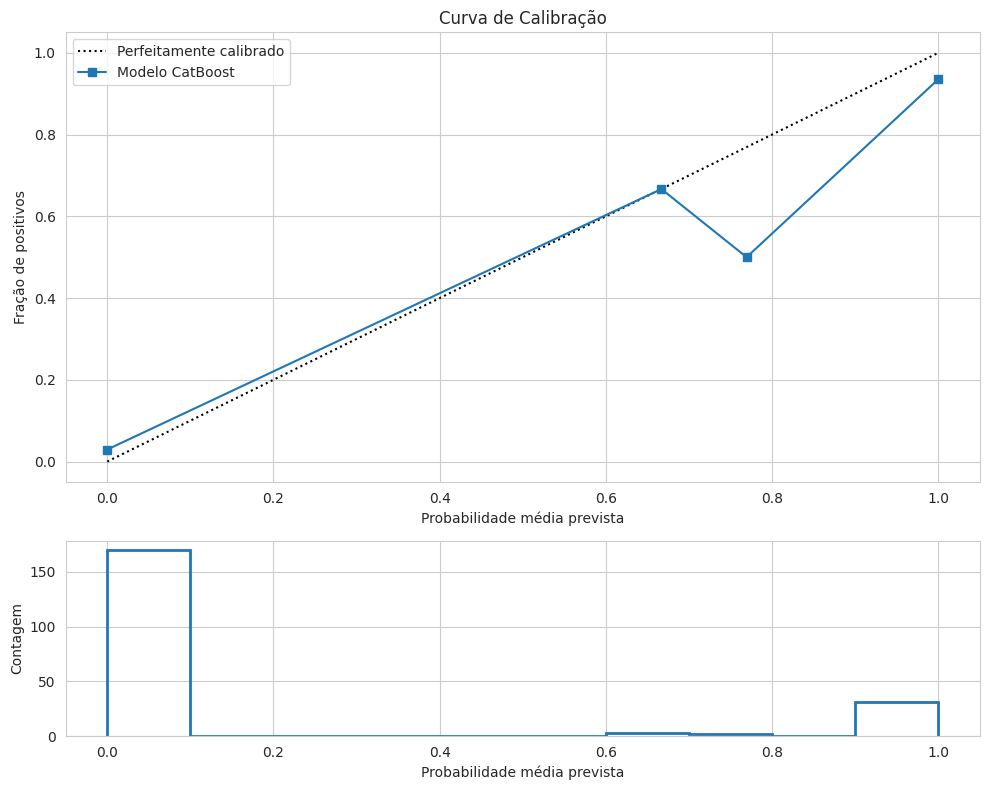


--- Análise de Features com SHAP ---


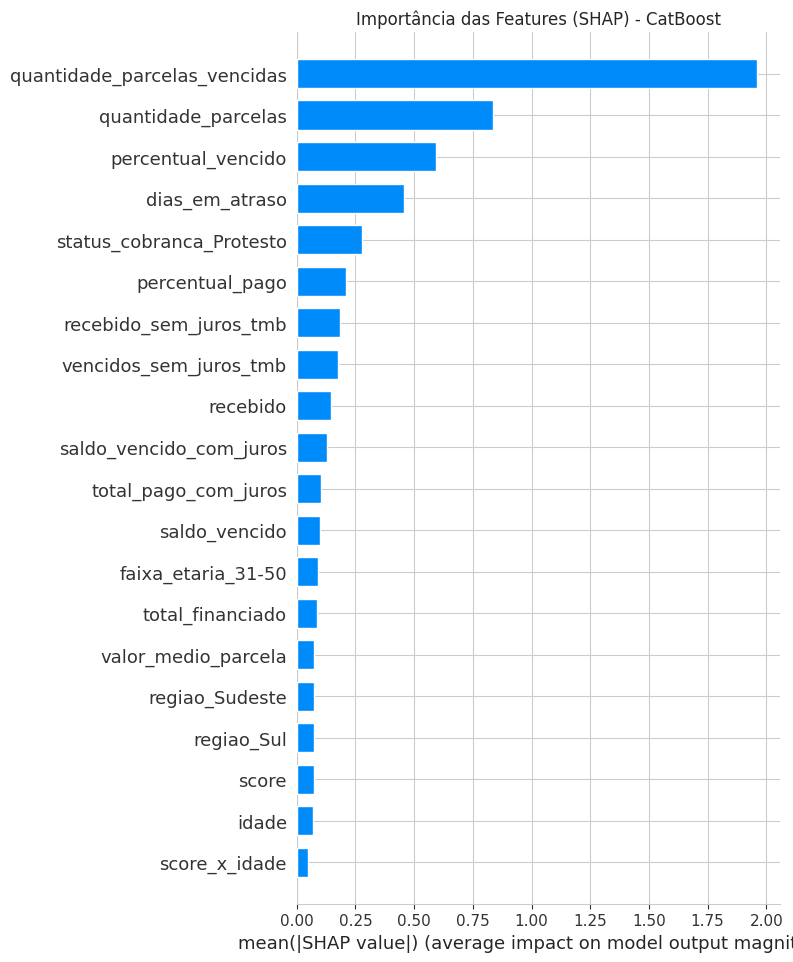


>>> Salvando o pipeline campeão em: pipeline_campeaoBaixo.joblib
Pipeline campeão salvo com sucesso!

Para visualizar todos os experimentos, métricas e modelos registrados:
1. Abra o terminal ou prompt de comando.
2. Navegue até o diretório onde este script está salvo.
3. Execute o comando: mlflow ui
4. Abra o seu navegador e acesse http://127.0.0.1:5000


In [16]:
# ==============================================================================
# 0. IMPORTAÇÃO DAS BIBLIOTECAS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import joblib
import warnings
import mlflow
import mlflow.sklearn
import shap
from datetime import datetime

# Pré-processamento e Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline

# Modelos
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Otimização e Calibração
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Métricas de Avaliação
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, f1_score, roc_auc_score, 
                             precision_score, recall_score, classification_report)

# Configurações
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# ==============================================================================
# 1. CONFIGURAÇÕES E SETUP DO MLFLOW
# ==============================================================================
DATA_FILE_PATH = 'Base8mil.xlsx'
TARGET_VARIABLE = 'pagamento'
EXPERIMENT_NAME = f"Competicao_Modelos_Protesto_{datetime.now().strftime('%Y-%m-%d')}"

SCORE_ESCOLHIDO = 'Baixo'  # 'Baixo', 'Médio', 'Alto'

df_raw = pd.read_excel(DATA_FILE_PATH)

df_raw.drop_duplicates(inplace=True)

df_raw = df_raw[df_raw['categoria_risco_score'] == SCORE_ESCOLHIDO]
print(SCORE_ESCOLHIDO, df_raw.shape)

dftotrain, dftotest = train_test_split(
    df_raw,
    test_size=0.3, # Separando 30% para o teste final
    random_state=42, 
    stratify=df_raw['Pagamento '] # MUITO IMPORTANTE para manter a proporção
)

print(dftotest.shape)
print(dftotrain.shape)


df1 = dftotrain.copy()

mlflow.set_experiment(EXPERIMENT_NAME)
print(f"MLflow Experiment '{EXPERIMENT_NAME}' configurado.")

# ==============================================================================
# 2. FUNÇÕES DE CARGA, VALIDAÇÃO E ENGENHARIA DE FEATURES
# ==============================================================================
def load_and_clean_data(dftotrain):
    print(">>> Etapa 1.1: Carregando e limpando dados...")
    df = dftotrain.copy()
    df.columns = [inflection.underscore(c).strip() for c in df.columns]
    
    if TARGET_VARIABLE not in df.columns:
        raise ValueError(f"A coluna alvo '{TARGET_VARIABLE}' não foi encontrada.")
        
    df[TARGET_VARIABLE] = df[TARGET_VARIABLE].str.strip().replace('Pago no Cartório', 'Pagos TMB')
    df = df[df[TARGET_VARIABLE].isin(['Pagos TMB', 'Não foram pagos'])]
    df[TARGET_VARIABLE] = df[TARGET_VARIABLE].map({'Não foram pagos': 0, 'Pagos TMB': 1})
    df.dropna(subset=[TARGET_VARIABLE], inplace=True)
    return df

def validate_data_initial(df):
    print(">>> Etapa 1.2: Validando dados iniciais...")
    required_cols = ['score', 'idade', 'total_financiado']
    for col in required_cols:
        assert col in df.columns, f"Coluna obrigatória '{col}' não encontrada."
    
    assert df['score'].dropna().between(0, 1000).all(), "Valores de 'score' fora do intervalo esperado [0, 1000]."
    assert df['idade'].dropna().between(18, 120).all(), "Valores de 'idade' fora do intervalo esperado [18, 120]."
    print("Validação de dados iniciais concluída com sucesso.")
    return True

def engineer_features(df):
    print(">>> Etapa 1.3: Realizando engenharia de features...")
    df_eng = df.copy()
    
    df_eng['faixa_etaria'] = pd.cut(df_eng['idade'], bins=[0, 30, 50, 65, 120], labels=['18-30', '31-50', '51-65', '65+'])
    df_eng['score_x_idade'] = df_eng['score'] * df_eng['idade']
    df_eng['score_ao_quadrado'] = df_eng['score'] ** 2
    df_eng['score_por_idade'] = df_eng['score'] / (df_eng['idade'] + 1)
    
    mapa_regioes = {
        'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
        'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
        'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
        'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
        'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
    }
    df_eng['regiao'] = df_eng['endereco_estado'].str.upper().str.strip().map(mapa_regioes).fillna('Outra')
    
    df_eng['percentual_vencido'] = (df_eng['saldo_vencido'] / df_eng['total_financiado']).fillna(0)
    df_eng['percentual_pago'] = (df_eng['recebido'] / df_eng['total_financiado']).fillna(0)
    df_eng['valor_medio_parcela'] = (df_eng['quantidade_parcelas'] / df_eng['total_financiado']).fillna(0)
    
    df_eng.replace([np.inf, -np.inf], 0, inplace=True)
    return df_eng

# ==============================================================================
# 3. WORKFLOW DE TREINAMENTO E AVALIAÇÃO (ENCAPSULADO)
# ==============================================================================
def run_experiment(model_name, estimator, search_space, X_train, y_train, X_test, y_test, preprocessor):
    """Encapsula o tuning, treinamento, calibração e avaliação de um modelo."""
    
    with mlflow.start_run(run_name=f"Tune_{model_name}") as run:
        print(f"\n--- Otimizando {model_name} ---")
        mlflow.log_param("model_name", model_name)
        
        pipeline_for_tuning = ImblearnPipeline(steps=[
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('model', estimator)
        ])
        
        cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        bayes_cv = BayesSearchCV(
            estimator=pipeline_for_tuning, search_spaces=search_space, n_iter=30, 
            cv=cv_strategy, scoring='f1', n_jobs=-1, random_state=42, verbose=0
        )
        bayes_cv.fit(X_train, y_train)
        
        print(f"Melhor F1-score (CV): {bayes_cv.best_score_:.4f}")
        mlflow.log_metric("f1_cv", bayes_cv.best_score_)
        mlflow.log_params(bayes_cv.best_params_)

        print(f"Treinando e calibrando {model_name}...")
        final_pipeline = bayes_cv.best_estimator_
        # Note: A calibração é feita no pipeline que já inclui SMOTE. 
        # A predição será em dados não "SMOTados", que é o correto.
        # cv='prefit' reusa o modelo já treinado.
        calibrated_pipeline = CalibratedClassifierCV(final_pipeline, method='isotonic', cv='prefit')
        calibrated_pipeline.fit(X_train, y_train)

        y_pred = calibrated_pipeline.predict(X_test)
        metrics = {
            "accuracy_test": accuracy_score(y_test, y_pred),
            "f1_test": f1_score(y_test, y_pred),
            "precision_test": precision_score(y_test, y_pred),
            "recall_test": recall_score(y_test, y_pred),
            "roc_auc_test": roc_auc_score(y_test, calibrated_pipeline.predict_proba(X_test)[:, 1])
        }
        
        print(f"F1-score (Teste): {metrics['f1_test']:.4f}")
        print('accuracy_score',accuracy_score(y_test, y_pred)* 100)
        print(classification_report(y_test, y_pred))
        mlflow.log_metrics(metrics)
        
        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=['Não Pagará', 'Pagará'], yticklabels=['Não Pagará', 'Pagará'])
        ax.set_title(f'Matriz de Confusão - {model_name}')
        ax.set_ylabel('Verdadeiro')
        ax.set_xlabel('Previsto')
        mlflow.log_figure(fig, f"confusion_matrix_{model_name}.png")
        plt.close(fig)
        
        mlflow.sklearn.log_model(calibrated_pipeline, f"model_{model_name}")
        
        return run.info.run_id, metrics['f1_test']

# ==============================================================================
# 4. EXECUÇÃO PRINCIPAL DO WORKFLOW
# ==============================================================================
# --- Carga e Preparação ---
df = load_and_clean_data(df1)
df_featured = engineer_features(df)

initial_rows = len(df_featured)
df_featured = df_featured[df_featured['idade'].between(18, 120)]
print(f"\n>>> Foram removidas {initial_rows - len(df_featured)} linhas com idade fora do intervalo [18, 120].")

validate_data_initial(df_featured) 

# --- Definição de Features ---
FEATURES = [
    'score', 'idade', 'total_financiado', 'quantidade_parcelas', 'saldo_vencido',
    'quantidade_parcelas_vencidas', 'recebido', 'dias_em_atraso',
    'saldo_vencido_com_juros', 'total_pago_com_juros', 'vencidos_sem_juros_tmb',
    'recebido_sem_juros_tmb', 'score_x_idade', 'score_ao_quadrado', 'score_por_idade',
    'percentual_vencido', 'percentual_pago', 'valor_medio_parcela',
    'status_cobranca', 'faixa_etaria', 'regiao', 'segmento',
    'categoria_risco_score', 'modalidade', 'pdd'
]
NUMERIC_FEATURES = df_featured[FEATURES].select_dtypes(include=np.number).columns.tolist()
CATEGORICAL_FEATURES = df_featured[FEATURES].select_dtypes(exclude=np.number).columns.tolist()

X = df_featured[FEATURES]
y = df_featured[TARGET_VARIABLE]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Definição do Pré-Processador ---
numeric_transformer = SklearnPipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())])
categorical_transformer = SklearnPipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, NUMERIC_FEATURES), ('cat', categorical_transformer, CATEGORICAL_FEATURES)], remainder='passthrough')

# --- Definição dos Modelos e Espaços de Busca ---
models_config = [
    {'name': 'XGBoost', 'estimator': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), 'search_space': {'model__n_estimators': Integer(100, 500), 'model__learning_rate': Real(0.01, 0.2, 'log-uniform'), 'model__max_depth': Integer(4, 8)}},
    {'name': 'LightGBM', 'estimator': LGBMClassifier(random_state=42, verbose=-1), 'search_space': {'model__n_estimators': Integer(100, 500), 'model__learning_rate': Real(0.01, 0.2, 'log-uniform'), 'model__num_leaves': Integer(20, 40)}},
    {'name': 'CatBoost', 'estimator': CatBoostClassifier(random_state=42, verbose=0), 'search_space': {'model__n_estimators': Integer(100, 500), 'model__learning_rate': Real(0.01, 0.2, 'log-uniform'), 'model__depth': Integer(4, 8)}}
]

# --- Execução da Competição ---
results = []
for config in models_config:
    run_id, test_f1 = run_experiment(
        model_name=config['name'], estimator=config['estimator'], search_space=config['search_space'],
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, preprocessor=preprocessor
    )
    results.append({'run_id': run_id, 'name': config['name'], 'f1_test': test_f1})

# ==============================================================================
# 5. ANÁLISE DO CAMPEÃO E SALVAMENTO
# ==============================================================================
champion_result = max(results, key=lambda x: x['f1_test'])
print(f"\n=======================================================================")
print(f"🏆 MODELO CAMPEÃO: {champion_result['name']} com F1-score de teste de {champion_result['f1_test']:.4f}")
print(f"Run ID no MLflow: {champion_result['run_id']}")
print(f"=======================================================================")

# --- Carrega o modelo campeão do MLflow ---
champion_model_uri = f"runs:/{champion_result['run_id']}/model_{champion_result['name']}"
champion_pipeline = mlflow.sklearn.load_model(champion_model_uri)

# --- Análise Aprofundada do Campeão ---
print(f"\n>>> Análise detalhada do {champion_result['name']}...")

y_pred_champion = champion_pipeline.predict(X_test)
y_proba_champion = champion_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Relatório de Classificação do Modelo Campeão ---")
print(classification_report(y_test, y_pred_champion, target_names=['Não Pagará', 'Pagará']))

plt.figure(figsize=(10, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")
prob_true, prob_pred = calibration_curve(y_test, y_proba_champion, n_bins=10, strategy='uniform')
ax1.plot(prob_pred, prob_true, "s-", label=f"Modelo {champion_result['name']}")
ax1.set(ylabel="Fração de positivos", xlabel="Probabilidade média prevista", ylim=[-0.05, 1.05], title='Curva de Calibração')
ax1.legend()
ax2.hist(y_proba_champion, range=(0, 1), bins=10, histtype="step", lw=2)
ax2.set(xlabel="Probabilidade média prevista", ylabel="Contagem")
plt.tight_layout()
plt.show()

print("\n--- Análise de Features com SHAP ---")
# --- 2ª CORREÇÃO ---
# Acessa o pipeline original através do atributo .estimator
base_model = champion_pipeline.estimator.named_steps['model']
preprocessor_shap = champion_pipeline.estimator.named_steps['preprocessor']

# Garante que a transformação para o SHAP use um DataFrame com as colunas corretas
X_test_transformed = preprocessor_shap.transform(X_test)
ohe_names = preprocessor_shap.named_transformers_['cat']['onehot'].get_feature_names_out(CATEGORICAL_FEATURES)
feature_names_transformed = NUMERIC_FEATURES + list(ohe_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names_transformed)

explainer = shap.TreeExplainer(base_model)
shap_values = explainer.shap_values(X_test_transformed_df) 

shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar", show=False, max_display=20)
plt.title(f"Importância das Features (SHAP) - {champion_result['name']}")
plt.show()

# --- Salva o artefato final ---
CHAMPION_MODEL_PATH = f"pipeline_campeao{SCORE_ESCOLHIDO}.joblib"
print(f"\n>>> Salvando o pipeline campeão em: {CHAMPION_MODEL_PATH}")
joblib.dump(champion_pipeline, CHAMPION_MODEL_PATH)
print("Pipeline campeão salvo com sucesso!")

# ==============================================================================
# 6. COMO VISUALIZAR OS RESULTADOS NO MLFLOW
# ==============================================================================
print("\nPara visualizar todos os experimentos, métricas e modelos registrados:")
print("1. Abra o terminal ou prompt de comando.")
print(f"2. Navegue até o diretório onde este script está salvo.")
print("3. Execute o comando: mlflow ui")
print("4. Abra o seu navegador e acesse http://127.0.0.1:5000")

# Run Model

In [17]:
def clean_column_names(df):
    """Padroniza os nomes das colunas para snake_case."""
    df_copy = df.copy()
    df_copy.columns = [inflection.underscore(c).strip() for c in df_copy.columns]
    return df_copy

def engineer_features_master(df):
    """
    Executa a engenharia de features de forma consistente.
    Esta função deve ser a ÚNICA fonte da verdade para treino e previsão.
    """
    df_eng = df.copy()
    
    # --- Limpeza de colunas monetárias (tratamento robusto) ---
    # Garante que valores como 'R$ 1.234,56' se tornem floats 1234.56
    cols_to_convert = [
        'total_financiado', 'saldo_vencido', 'recebido', 
        'saldo_vencido_com_juros', 'total_pago_com_juros', 
        'vencidos_sem_juros_tmb', 'recebido_sem_juros_tmb'
    ]
    
    for col in cols_to_convert:
        if col in df_eng.columns:
            # Converte para string pra garantir que o .str funcione
            df_eng[col] = df_eng[col].astype(str)
            df_eng[col] = df_eng[col].str.replace('R$', '', regex=False).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).str.strip()
            # Converte para numérico, forçando erros a virarem NaN, que depois serão tratados
            df_eng[col] = pd.to_numeric(df_eng[col], errors='coerce')

    # --- Criação de Novas Features ---
    df_eng['faixa_etaria'] = pd.cut(df_eng['idade'], bins=[0, 30, 50, 65, 120], labels=['18-30', '31-50', '51-65', '65+'])
    df_eng['score_x_idade'] = df_eng['score'] * df_eng['idade']
    df_eng['score_ao_quadrado'] = df_eng['score'] ** 2
    df_eng['score_por_idade'] = df_eng['score'] / (df_eng['idade'] + 1)
    
    mapa_regioes = {
        'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
        'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
        'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
        'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
        'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
    }
    df_eng['regiao'] = df_eng['endereco_estado'].str.upper().str.strip().map(mapa_regioes).fillna('Outra')
    
    df_eng['percentual_vencido'] = (df_eng['saldo_vencido'] / df_eng['total_financiado'])
    df_eng['percentual_pago'] = (df_eng['recebido'] / df_eng['total_financiado'])
    df_eng['valor_medio_parcela'] = (df_eng['quantidade_parcelas'] / df_eng['total_financiado'])
    
    # Substitui infinitos (gerados por divisão por zero) e NaNs por 0
    df_eng.replace([np.inf, -np.inf], 0, inplace=True)
    
    numeric_cols = df_eng.select_dtypes(include=np.number).columns
    df_eng[numeric_cols] = df_eng[numeric_cols].fillna(0)
    
    # Para colunas do tipo Categoria, primeiro ADICIONAMOS a categoria 'Desconhecido'
    # antes de tentar usá-la para preencher os NaNs.
    categorical_cols = df_eng.select_dtypes(include=['category']).columns
    for col in categorical_cols:
        # Verifica se a coluna é do tipo 'category'
        if pd.api.types.is_categorical_dtype(df_eng[col]):
            # Verifica se a categoria 'Desconhecido' já não existe
            if 'Desconhecido' not in df_eng[col].cat.categories:
                df_eng[col] = df_eng[col].cat.add_categories('Desconhecido')

    # Agora sim, preenchemos tudo que for texto ou categoria com o placeholder
    object_and_cat_cols = df_eng.select_dtypes(include=['object', 'category']).columns
    df_eng[object_and_cat_cols] = df_eng[object_and_cat_cols].fillna('Desconhecido')
    
    
    return df_eng

In [18]:
MODELO_CAMPEAO = f"pipeline_campeao{SCORE_ESCOLHIDO}.joblib"
# Carrega o modelo treinado (que é um pipeline completo)
try:
    model_pipeline = joblib.load(MODELO_CAMPEAO)
    print(f"✅ Modelo '{MODELO_CAMPEAO}' carregado com sucesso.")
except FileNotFoundError:
    print(f"❌ ERRO: O arquivo '{MODELO_CAMPEAO}' não foi encontrado. Verifique o nome e o caminho.")
    # Interrompe a execução se o modelo não for encontrado
    raise

# Assume que 'dftotest' já está carregado na memória do notebook, como no seu script original
# Se não estiver, carregue o Excel aqui: df_raw = pd.read_excel('Base8mil.xlsx')
# dftotest = df_raw.loc[0:3000]

# Filtra os dados de teste para o mesmo score do treino
df_para_prever_raw = dftotest[dftotest['categoria_risco_score'] == SCORE_ESCOLHIDO].copy()

# Guarda o dataframe original para juntar os resultados no final
df_original_com_target = df_para_prever_raw.copy()


# --- APLICA A PREPARAÇÃO PADRONIZADA ---
print("\nIniciando preparação dos dados para previsão...")
df_padronizado = clean_column_names(df_para_prever_raw)
df_com_features = engineer_features_master(df_padronizado)
print("✅ Dados preparados.")


# --- GARANTE QUE AS COLUNAS ESTÃO CORRETAS E NA ORDEM CERTA ---
# Esta lista DEVE ser idêntica à lista 'FEATURES' do script de treino
FEATURES = [
    'score', 'idade', 'total_financiado', 'quantidade_parcelas', 'saldo_vencido',
    'quantidade_parcelas_vencidas', 'recebido', 'dias_em_atraso',
    'saldo_vencido_com_juros', 'total_pago_com_juros', 'vencidos_sem_juros_tmb',
    'recebido_sem_juros_tmb', 'score_x_idade', 'score_ao_quadrado', 'score_por_idade',
    'percentual_vencido', 'percentual_pago', 'valor_medio_parcela',
    'status_cobranca', 'faixa_etaria', 'regiao', 'segmento',
    'categoria_risco_score', 'modalidade', 'pdd'
]

# Checagem final de sanidade
for feature in FEATURES:
    if feature not in df_com_features.columns:
        raise ValueError(f"ERRO: A feature obrigatória '{feature}' não foi encontrada após a preparação.")

# Seleciona e ordena as colunas exatamente como o modelo espera
df_pronto_para_previsao = df_com_features[FEATURES]

print(f"✅ DataFrame final pronto com {df_pronto_para_previsao.shape[1]} colunas na ordem correta.")

✅ Modelo 'pipeline_campeaoBaixo.joblib' carregado com sucesso.

Iniciando preparação dos dados para previsão...
✅ Dados preparados.
✅ DataFrame final pronto com 25 colunas na ordem correta.


In [19]:
print("\nExecutando previsões...")
# O pipeline cuida de tudo: imputação, scaling, one-hot encoding, etc.
previsoes = model_pipeline.predict(df_pronto_para_previsao)
probabilidades = model_pipeline.predict_proba(df_pronto_para_previsao)[:, 1] # Pega só a prob da classe 1 (pagar)
print("✅ Previsões concluídas.")

# --- Montar o DataFrame de resultados ---
df_resultados = df_original_com_target.reset_index(drop=True)
df_resultados['previsao'] = previsoes
df_resultados['previsao_label'] = df_resultados['previsao'].map({0: 'Não Pagará', 1: 'Pagará'})
df_resultados['prob_pagar'] = probabilidades * 100

print(f"\nProbabilidade média de pagamento na amostra: {df_resultados['prob_pagar'].mean():.2f}%")
display(df_resultados[['pedido_id', 'Pagamento ', 'previsao_label', 'prob_pagar']].head())


Executando previsões...
✅ Previsões concluídas.

Probabilidade média de pagamento na amostra: 16.59%


,pedido_id,Pagamento,previsao_label,prob_pagar
0,585376,Pagos TMB,Pagará,100.0
1,813224,Não foram pagos,Não Pagará,0.0
2,1271661,Não foram pagos,Não Pagará,0.0
3,687390,Não foram pagos,Não Pagará,0.0
4,979395,Não foram pagos,Não Pagará,0.0


--- RELATÓRIO DE CLASSIFICAÇÃO NO TESTE ---
                precision    recall  f1-score   support

Não Pagará (0)       0.95      0.96      0.96       361
    Pagará (1)       0.83      0.78      0.80        80

      accuracy                           0.93       441
     macro avg       0.89      0.87      0.88       441
  weighted avg       0.93      0.93      0.93       441


--- MATRIZ DE CONFUSÃO (EM QUANTIDADE) ---


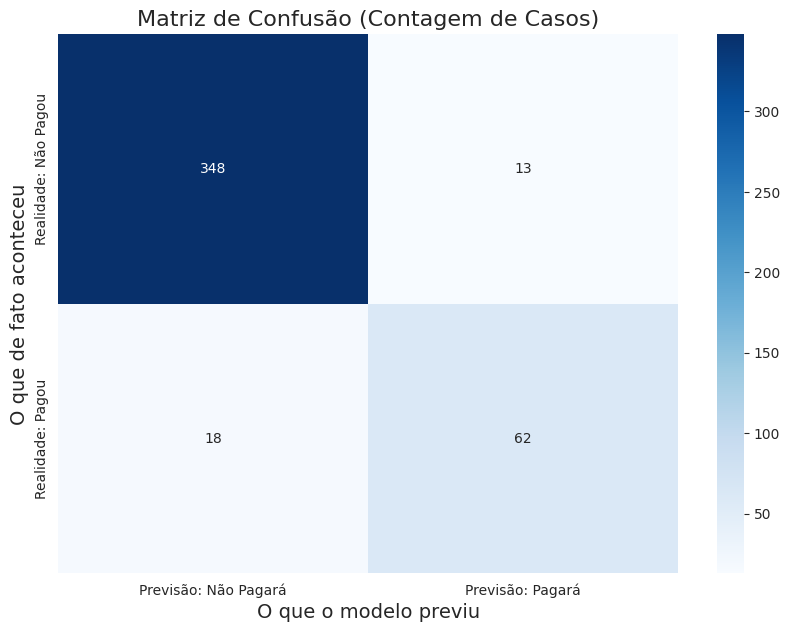



--- ANÁLISE DE ACERTO (EM %) ---

Dos 361 clientes que REALMENTE NÃO PAGARAM:
  - ACERTOU: O modelo previu 'Não Pagará' em 96.40% dos casos (348 clientes).
  - ERROU: O modelo previu 'Pagará' em 3.60% dos casos (13 clientes).

Dos 80 clientes que REALMENTE PAGARAM:
  - ACERTOU: O modelo previu 'Pagará' em 77.50% dos casos (62 clientes).
  - ERROU: O modelo previu 'Não Pagará' em 22.50% dos casos (18 clientes).


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Preparar a coluna de "verdade" (target) ---
# CORREÇÃO: Removido o espaço extra da chave 'Não foram pagos'
mapa_pagamento = {'Pagos TMB': 1, 'Pago no Cartório': 1, 'Não foram pagos': 0}

# O .str.strip() remove espaços em branco dos valores da coluna
df_resultados['target_real'] = df_resultados['Pagamento '].str.strip().map(mapa_pagamento)

# Remove linhas onde o pagamento real é desconhecido (se houver)
df_validacao = df_resultados.dropna(subset=['target_real', 'previsao'])

# Converte para inteiro para garantir que a métrica funcione
df_validacao['target_real'] = df_validacao['target_real'].astype(int)


# --- Gerar Relatório de Classificação ---
print("--- RELATÓRIO DE CLASSIFICAÇÃO NO TESTE ---")
print(classification_report(df_validacao['target_real'], df_validacao['previsao'], target_names=['Não Pagará (0)', 'Pagará (1)']))


# --- 1. GRÁFICO COM A CONTAGEM DE CASOS ---
print("\n--- MATRIZ DE CONFUSÃO (EM QUANTIDADE) ---")

# Calcula a matriz de confusão com as contagens
cm = confusion_matrix(df_validacao['target_real'], df_validacao['previsao'])

# Cria o gráfico da matriz de confusão com as contagens
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsão: Não Pagará', 'Previsão: Pagará'],
            yticklabels=['Realidade: Não Pagou', 'Realidade: Pagou'])

plt.title('Matriz de Confusão (Contagem de Casos)', fontsize=16)
plt.ylabel('O que de fato aconteceu', fontsize=14)
plt.xlabel('O que o modelo previu', fontsize=14)
plt.show()


# --- 2. TEXTO NO CONSOLE COM AS PORCENTAGENS ---
print("\n\n--- ANÁLISE DE ACERTO (EM %) ---")

# Extrai os valores da matriz:
# cm = [[Verdadeiro Negativo, Falso Positivo],
#       [Falso Negativo,    Verdadeiro Positivo]]
TN, FP, FN, TP = cm.ravel()

total_nao_pagou = TN + FP
total_pagou = FN + TP

# Evita divisão por zero se uma classe não estiver presente
if total_nao_pagou > 0:
    acerto_nao_pagou = (TN / total_nao_pagou) * 100
    erro_nao_pagou = (FP / total_nao_pagou) * 100
    print(f"\nDos {total_nao_pagou} clientes que REALMENTE NÃO PAGARAM:")
    print(f"  - ACERTOU: O modelo previu 'Não Pagará' em {acerto_nao_pagou:.2f}% dos casos ({TN} clientes).")
    print(f"  - ERROU: O modelo previu 'Pagará' em {erro_nao_pagou:.2f}% dos casos ({FP} clientes).")
else:
    print("\nNão há dados para a classe 'Não Pagou' no conjunto de teste.")

if total_pagou > 0:
    acerto_pagou = (TP / total_pagou) * 100
    erro_pagou = (FN / total_pagou) * 100
    print(f"\nDos {total_pagou} clientes que REALMENTE PAGARAM:")
    print(f"  - ACERTOU: O modelo previu 'Pagará' em {acerto_pagou:.2f}% dos casos ({TP} clientes).")
    print(f"  - ERROU: O modelo previu 'Não Pagará' em {erro_pagou:.2f}% dos casos ({FN} clientes).")
else:
    print("\nNão há dados para a classe 'Pagou' no conjunto de teste.")

In [21]:
# Salva o arquivo com os resultados
output_filename = f'Resultados_Protestados_{SCORE_ESCOLHIDO}_VALIDADO.csv'
df_resultados.to_csv(output_filename, sep=';', index=False, decimal=',')
print(f"\n✅ Arquivo com resultados salvo como '{output_filename}'")


✅ Arquivo com resultados salvo como 'Resultados_Protestados_Baixo_VALIDADO.csv'
